In [ ]:
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [ ]:
words = open('names.txt', 'r').read().split()
len(words)

In [ ]:
words[:5]

In [ ]:
vocab = sorted(list(set(''.join(words))) + ['.'])
vocab_size = len(vocab)

stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for ch, i in stoi.items()}


In [ ]:
block_size = 3
emb_dim = 20
n_hidden = 200
batch_size = 64

In [ ]:
def build_dataset(words):
    X, y = [], []

    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            y.append(ix)
            # print(''.join(itos[i] for i in context), '-->', itos[ix] )
            context = context[1:] + [ix]

    X = torch.tensor(X)
    y = torch.tensor(y)
    print(X.shape, y.shape)
    return X,y

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

Xtr,ytr = build_dataset(words[:n1])
Xdev,ydev = build_dataset(words[n1:n2])
Xte,yte = build_dataset(words[n2:])

In [ ]:
C = torch.randn((vocab_size,emb_dim))
W1 = (5/3) * torch.randn((block_size * emb_dim, n_hidden)) / (block_size*emb_dim)**0.5
b1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn((n_hidden, vocab_size)) * 0.1
b2 = torch.randn(vocab_size) * 0.0

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

print(sum(p.numel() for p in parameters), "parameters")

In [ ]:
for i in range(200000):
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], size=(batch_size,))
    Xb, yb = Xtr[ix], ytr[ix]

    emb = C[Xb]
    hpreact = emb.view(-1,block_size*emb_dim) @ W1 + b1 # (12,6) @ (6,100) -> (batch_size,200)
    hpreact = bngain * ((hpreact - hpreact.mean(dim=0, keepdim=True))) / hpreact.std(dim=0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (12,100) @ (100,27) -> (12,27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)

    # loss = - prob[torch.arange(Xb.shape[0]), yb].log().mean()
    loss = F.cross_entropy(logits, yb)

    if i % 20000 == 0 or i == 0:
        print(f'Iteration {i} | loss = {loss.item():.4f}')

    for p in parameters:
        p.grad = None

    loss.backward()

    # updates
    lr = 0.1 if i < 50000 else 0.01
    for p in parameters:
        p.data += -(lr * p.grad)
    

In [ ]:
# calculate training hpreact mean and std

with torch.no_grad():
    emb = C[Xtr]
    hpreact = emb.view(-1,block_size*emb_dim) @ W1 + b1 # (12,6) @ (6,100) -> (batch_size,200)
    bnmean = hpreact.mean(dim=0, keepdim=True)
    bnstd = hpreact.std(dim=0, keepdim=True)

In [ ]:
# Looking at the loss on entire dev data after some training

with torch.no_grad():
    emb = C[Xdev]
    hpreact = emb.view(-1,block_size*emb_dim) @ W1 + b1 # (12,6) @ (6,100) -> (batch_size,200)
    hpreact = bngain * ((hpreact - bnmean)) / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, ydev)

loss.item()

In [ ]:
for _ in range(5):
    context = [0] * block_size
    out = []
    while True:
        
        x = C[context]
        h = torch.tanh(x.view(-1,block_size*emb_dim) @ W1 + b1)
        logits = h @ W2 + b2
        counts = logits.exp() # (1,27)
        prob = counts / counts.sum(1, keepdim=True) # (1,27)

        ix = torch.multinomial(prob, num_samples=1, replacement=True).item()
        out.append(itos[ix])
        context = context[1:] + [ix]
        if ix == 0:
            break
    print(''.join(out))

### Find appropriate learning rate

In [ ]:
# # (0.001 , 1) -> (10^-3, 10^0)
# lre = torch.linspace(-3, 0, 1000)
# lrs = 10**lre

In [ ]:
# C = torch.randn((vocab_size,emb_dim))
# W1 = torch.randn((block_size * emb_dim, n_hidden))
# b1 = torch.randn(n_hidden)
# W2 = torch.randn((n_hidden, vocab_size))
# b2 = torch.randn(vocab_size)

# parameters = [C, W1, b1, W2, b2]

# for p in parameters:
#     p.requires_grad = True

# print(sum(p.numel() for p in parameters), "parameters")

In [ ]:
# lossi = []
# lri = []

# for i in range(1000):

#     # mini-batch construct
#     ix = torch.randint(0, X.shape[0], size=(batch_size,))
#     Xb, yb = Xtr[ix], y[ix]

#     emb = C[Xb]
#     h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (12,6) @ (6,100) -> (12,100)
#     logits = h @ W2 + b2 # (12,100) @ (100,27) -> (12,27)

#     loss = F.cross_entropy(logits, yb)
#     # if i % 1000 == 0 or i == 0:
#     #     print(f'Iteration {i} | loss = {loss.item():.4f}')

#     for p in parameters:
#         p.grad = None

#     loss.backward()

#     # updates
#     lr = lrs[i]
#     for p in parameters:
#         p.data += -(lr * p.grad)
#     lri.append(lr)
#     lossi.append(loss.item())

In [ ]:
import matplotlib.pyplot as plt
plt.plot(lre, lossi)
plt.xlabel('lre')
plt.ylabel('loss')
plt.show()

# PyTorch-ifying the code

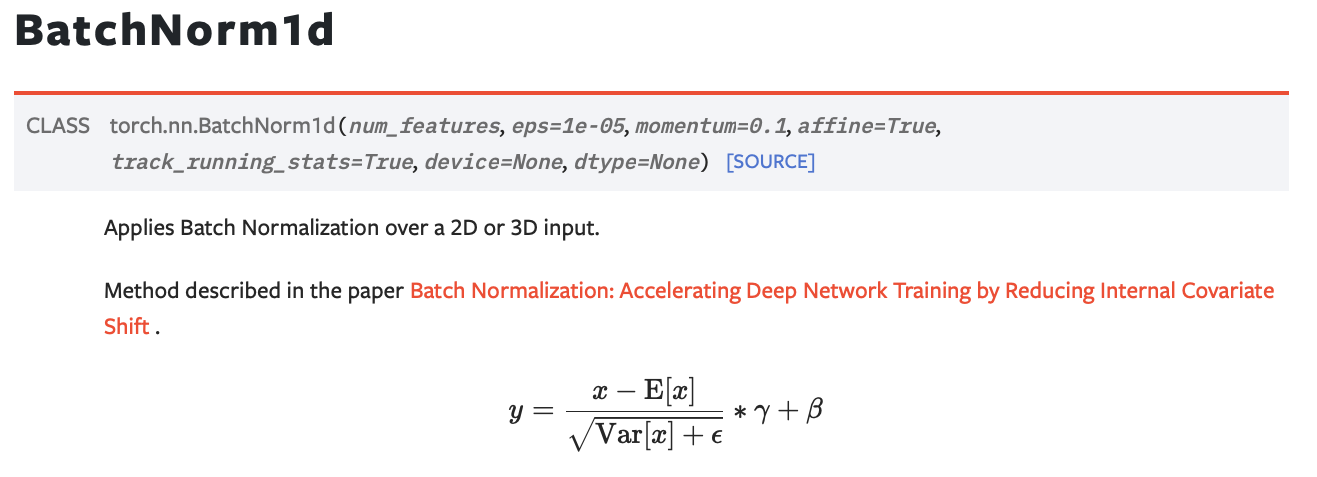

In [ ]:
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn(num_embeddings, embedding_dim)

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1) # flattens all dimensions
        return self.out
    
    def parameters(self):
        return []

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

class BatchNorm1d:
    def __init__(self, dim, epsilon=1e-5, momentum=0.1):
        self.dim = dim
        self.epsilon = epsilon
        self.training = True
        self.momentum = momentum

        self.gamma = torch.ones(self.dim)
        self.beta = torch.zeros(self.dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        else:
            xmean = self.running_mean
            xvar = self.running_var

        hpreact = (x-xmean) / torch.sqrt(xvar + self.epsilon)
        self.out = self.gamma * hpreact + self.beta

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

# Let's simplify out layers into model : by PyTorch Containers
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
emb_dim = 10
n_hidden = 100
batch_size = 64

In [ ]:
# C = torch.rand((vocab_size, emb_dim))
layers = [
    Embedding(vocab_size, emb_dim),
    Flatten(),
    Linear(block_size*emb_dim, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    for l in layers[:-1]:
        if isinstance(l, Linear):
            l.weight *= (5/3)
 
    layers[-1].weight *= 0.1
    layers[1].bias = 0.0

parameters = [p for l in layers for p in l.parameters()]
print(sum(p.numel() for p in parameters), 'parameters in the model')

for p in parameters:
    p.requires_grad = True

In [ ]:
lossi = []
for i in range(200000):
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], size=(batch_size,))
    Xb, yb = Xtr[ix], ytr[ix]

    # emb = C[Xb]
    # x = emb.view(Xb.shape[0], -1)
    x = Xb
    for layer in layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, yb)
    lossi.append(loss.item())

    if i % 20000 == 0 or i == 0:
        print(f'Iteration {i} | loss = {loss.item():.4f}')

    for p in parameters:
        p.grad = None

    loss.backward()

    # updates
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -(lr * p.grad)


In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [ ]:
# Looking at the loss on entire dev data after some training

with torch.no_grad():
    x = Xdev
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, ydev)

loss.item()


# THIS IS WRONG, coz we are USING DEV stats for BATCHNORM calculation

### With Container: Sequential

In [ ]:

model = Sequential([
    Embedding(vocab_size, emb_dim),
    Flatten(),
    Linear(block_size*emb_dim, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    for l in layers[:-1]:
        if isinstance(l, Linear):
            l.weight *= (5/3)
 
    layers[-1].weight *= 0.1

parameters = model.parameters() #[p for l in layers for p in l.parameters()]
print(sum(p.numel() for p in parameters), 'parameters in the model')

for p in parameters:
    p.requires_grad = True

In [ ]:
lossi = []
for i in range(200000):
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], size=(batch_size,))
    Xb, yb = Xtr[ix], ytr[ix]

    logits = model(Xb)

    loss = F.cross_entropy(logits, yb)
    lossi.append(loss.item())

    if i % 20000 == 0 or i == 0:
        print(f'Iteration {i} | loss = {loss.item():.4f}')

    for p in parameters:
        p.grad = None

    loss.backward()

    # updates
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -(lr * p.grad)


In [ ]:
for layer in model.layers:
    layer.training = False

# model.eval()

In [ ]:
# evaluate loss

@torch.no_grad()
def split_loss(split):
    x,y = {'train': (Xtr, ytr),
           'dev':   (Xdev, ydev),
           'test':  (Xte, yte)}[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(f'loss for {split} set: {loss.item()}')

split_loss('train')
split_loss('dev')

In [ ]:
# let's sample names

for _ in range(5):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1, replacement=True).item()

        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))